### Algoritmos VQE

Marzo 2023,


Las técnicas VQE se usan ampliamente en computación cuántica de sistemas químicos para obtener los autovalores del hamiltoniano de los sistemas modelados.

También se utilizan ampliamente en problemas de optimización usando técnicas clásicas de ML y algoritmos con circuitos cuánticos variacionales.  

La optimización consistirá en obtener el valor de energía mínimo de un sistema, caracterizado por un hamiltoniano

Cuando el estado del sistema es un autovector, o una combinación lineal de autovectores (si es un estado degenerado), con autovalor λi mínimo, la energía mínima es simplemnente el valor esperado del hamiltoniano <H>

El papel del circuito variacional es crítico: deberá hacer evolucionar al sistema desde  el estado inicial a este estado especial con autovalor mínimo.
    
- Update a los recursos de librería de  Qiskit

https://qiskit.org/documentation/stable/0.19/stubs/qiskit.aqua.components.optimizers.SLSQP.html
https://medium.com/qiskit/introducing-qiskit-algorithms-with-qiskit-runtime-primitives-d89703ecfca3

Se han producido importantes cambios en los recursos ML, finanzas y ciencia de QISKIT trás la obsolescencia de qiskit.aqua

En el caso del algoritmo VQE actualizado, ahora se usa un estimador en lugar de una instancia cuántica, y SparsePauliOp en lugar de PauliSumOp (aunque PauliSumOp seguirá siendo compatible). En todo caso SparsePauliOp es más eficiente

Documentación SparsePauliOp (PauliSumOp obsoleto)

https://qiskit.org/documentation/stubs/qiskit.opflow.primitive_ops.PauliSumOp.html

Documentación VQE

https://qiskit.org/documentation/stubs/qiskit.algorithms.VQE.html

Documentación Twolocal

https://qiskit.org/documentation/stubs/qiskit.circuit.library.TwoLocal.html

In [1]:
from qiskit.circuit import QuantumCircuit
from qiskit.algorithms.minimum_eigensolvers import VQE 
from qiskit.algorithms.optimizers import SLSQP,COBYLA 
from qiskit.circuit.library import TwoLocal 
from qiskit.quantum_info import SparsePauliOp 
from qiskit.primitives import Estimator
from qiskit.opflow import I, X, Y, Z

#### Funciones auxiliares para manipular productos tensoriales de Pauli

In [2]:
import numpy as np
from collections import defaultdict
from functools import reduce
from itertools import product

In [3]:
# Genera diccionario con los productos tensoriales de Pauli
def hamiltonian_to_paulis(H):
    
    PAULIS = {
    "I": np.eye(2, dtype=complex),
    "X": np.array([[0, 1], [1, 0]], dtype=complex),
    "Y": np.array([[0, -1j], [1j, 0]], dtype=complex),
    "Z": np.array([[1, 0], [0, -1]], dtype=complex),
    }
    
    n = int(np.log2(len(H)))
    dims = 2 ** n

    if H.shape != (dims, dims):
        raise ValueError("La entrada debe de ser una matriz de dim 2^n x 2^n")

    clave_dic= ["".join(k) for k in product(PAULIS.keys(), repeat=n)]
    
    diccionario = defaultdict(int)

    for i, val in enumerate(product(PAULIS.values(), repeat=n)):
        base_mat = reduce(np.kron, val)
        coef = H.reshape(-1).dot(base_mat.reshape(-1)) / dims
        coef = np.real_if_close(coef).item()
        
        if not np.allclose(coef, 0):
            diccionario[clave_dic[i]] = coef

    return diccionario

# Convierte el diccionario de Paulis en lista para ser usada con `SparsePauliOp.from_list`
def dic_to_list(dic_paulis):
    lista=[]
    for clave in dic_paulis:
        lista.append((clave,dic_paulis[clave]))
    return(lista)

### Hamiltoniano y ansatz

### CNOT

Imaginemos un circuito cuántico compuesto por dos qubits, donde queremos implementar la compuerta CNOT controlada por el primer qubit y el segundo qubit como objetivo. El Hamiltoniano correspondiente a este problema es:

$$ H = \frac{1}{2} (\mathbb{1} + Z_1) \otimes \mathbb{1} + \frac{1}{2} ( \mathbb{1} - Z_1) \otimes X_2 $$

Donde $\mathbb{1}$ es la matriz identidad de $2\times2$ y $X_i, Y_i, Z_i$ son los operadores de Pauli correspondientes al qubit $i$.

Podemos expresar este Hamiltoniano como una suma de tensores de Pauli de la siguiente manera:

$$ H = \frac{1}{2} \left( \mathbb{1} \otimes \mathbb{1} + Z_1 \otimes \mathbb{1} + \mathbb{1} \otimes X_2 - Z_1 \otimes X_2 \right) $$

Aquí cada término del Hamiltoniano es un tensor de Pauli de orden 2, es decir, un producto tensorial de dos operadores de Pauli. Además, se puede comprobar fácilmente que este Hamiltoniano tiene los autovalores $\pm 1$, lo que indica que es un Hamiltoniano bien definido.

En este caso, el primer término corresponde a la energía del estado base, mientras que los otros tres términos corresponden a la energía de los estados excitados. La implementación del Hamiltoniano correspondiente a este problema en una computadora cuántica nos permitiría realizar la compuerta CNOT controlada por el primer qubit y el segundo qubit como objetivo.

El análisi algebraico de la expresión matricial de este operador proporciona los  valores propios: λ1 = 1, de multiplicidad 3, λ2 = -1, y vectores propios normalizados:

λ1 = 1

    |v1⟩ = |00⟩        = (0.71,0,0,0)
    |v2⟩ = |01⟩        = (0,0.71,0,0)
    |v3> = |10>+|11>   = (0,0,0.71,0.71)

λ2 = -1

    |v4⟩ = |11⟩ - |10⟩ = (0,0,-0.71,0,71)
    

El papel del circuito ansatz será hacer evolucionar al sistema desde el estado inicial |00⟩ a |v4⟩ con λ2 = -1, de modo que se tenga:

            H|v4> = -|v4> = (0,0,0.71,-0,71)
            <H>= <CNOT> = -1

In [4]:
# toy Ham = CNOT
H=np.array([[1,0,0,0], [0,1,0,0],[0,0,0,1], [0,0,1,0]],dtype=complex)

# CNOT equivalente circuital qiskit
#H=np.array([[1,0,0,0], [0,0,0,1],[0,0,1,0], [0,1,0,0]],dtype=complex)

print('Operador matricial:')
print(H)

dic_paulis=hamiltonian_to_paulis(H)
lista_paulis=dic_to_list(dic_paulis)

print('\nlista de tuplas de tensores Pauli')
print(lista_paulis)

Operador matricial:
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]]

lista de tuplas de tensores Pauli
[('II', 0.5), ('IX', 0.5), ('ZI', 0.5), ('ZX', -0.5)]


In [5]:
# Hamiltoniano en sumandos de tensores de Pauli en clase SparsePauliOp
ham= SparsePauliOp.from_list(lista_paulis) 
print(ham)

SparsePauliOp(['II', 'IX', 'ZI', 'ZX'],
              coeffs=[ 0.5+0.j,  0.5+0.j,  0.5+0.j, -0.5+0.j])


In [6]:
# Comprobación de que se ha sintetizado una CNOT
hmatrix=ham.to_matrix()
hmatrix

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j]])

### Ansatz

La elección del circuito paramétrico que usará el algoritmo variacional es fundamental ya que de su adaptabilidad  dependerá la velocidad de convergencia VQE.

Se usará un ansatz Twolocal con la siguiente arquitectura:

Qbits:2
Capas: 2 (número de veces que se repite.
Bloques de entidarelazamiento: 1 (CX)
Puertas de rotación: 2 (Ry,Ry)

La "finura" variacional queda determinada por la cantidad de parámetros del ansatz:

θi = qbits*Npuertas_rotación(capas + 1)

θi = 2*2(2+1) = 12

#### Documentación Twolocal

https://qiskit.org/documentation/stubs/qiskit.circuit.library.TwoLocal.html

In [7]:
ansatz = TwoLocal(2, rotation_blocks=['ry', 'ry'],reps=2, insert_barriers=True, entanglement_blocks='cx') 

print(ansatz.decompose().draw())

     ┌──────────┐┌──────────┐ ░       ░ ┌──────────┐┌──────────┐ ░       ░ »
q_0: ┤ Ry(θ[0]) ├┤ Ry(θ[2]) ├─░───■───░─┤ Ry(θ[4]) ├┤ Ry(θ[6]) ├─░───■───░─»
     ├──────────┤├──────────┤ ░ ┌─┴─┐ ░ ├──────────┤├──────────┤ ░ ┌─┴─┐ ░ »
q_1: ┤ Ry(θ[1]) ├┤ Ry(θ[3]) ├─░─┤ X ├─░─┤ Ry(θ[5]) ├┤ Ry(θ[7]) ├─░─┤ X ├─░─»
     └──────────┘└──────────┘ ░ └───┘ ░ └──────────┘└──────────┘ ░ └───┘ ░ »
«     ┌──────────┐┌───────────┐
«q_0: ┤ Ry(θ[8]) ├┤ Ry(θ[10]) ├
«     ├──────────┤├───────────┤
«q_1: ┤ Ry(θ[9]) ├┤ Ry(θ[11]) ├
«     └──────────┘└───────────┘


In [8]:
type(ansatz)

qiskit.circuit.library.n_local.two_local.TwoLocal

## VQE

Optimizadores:

https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.html

In [9]:
# quantum_instance = BasicAer.get_backend(“statevector_simulator”) -> obsoleto
estimador = Estimator() 
optimizer = COBYLA()

vqe = VQE(estimador, ansatz, optimizer) 
result = vqe.compute_minimum_eigenvalue(operator=ham) 

In [10]:
print('Iteraciones:',result.cost_function_evals)
print("Valor mínimo:",round(result.eigenvalue,3))


Iteraciones: 161
Valor mínimo: -1.0


In [11]:
param_opt=result.optimal_parameters
print("Parámetros óptimos:")
for clave in param_opt:
    print(clave,round(param_opt[clave],3))

Parámetros óptimos:
θ[0] -3.181
θ[1] -0.6
θ[2] -4.371
θ[3] -0.797
θ[4] -0.157
θ[5] 3.755
θ[6] 5.501
θ[7] 2.93
θ[8] -3.386
θ[9] -4.81
θ[10] 2.179
θ[11] -3.526


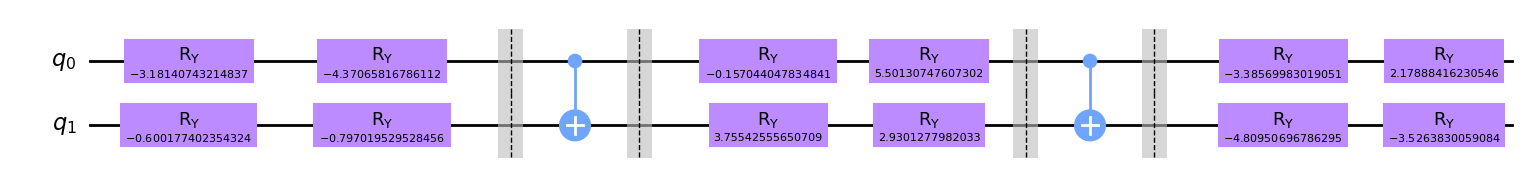

In [12]:
cir=[ansatz.bind_parameters(param_opt)][-1]

cir.decompose().draw('mpl')

### Obtención de vectores de estado

- Síntesis del circuito ansatz
- Incorporar circuito hamiltoniano a partir de su representación matricial
- Simular

In [13]:
from qiskit.quantum_info import Statevector
from qiskit.quantum_info.operators import Operator
from qiskit.visualization import array_to_latex

In [14]:
oper_ansatz=np.round(Operator(cir),2)
oper_ansatz

array([[-0.  +0.j, -0.16+0.j, -0.09+0.j,  0.98+0.j],
       [ 0.  +0.j, -0.36+0.j, -0.92+0.j, -0.14+0.j],
       [-0.71+0.j, -0.65+0.j,  0.26+0.j, -0.08+0.j],
       [ 0.71+0.j, -0.65+0.j,  0.26+0.j, -0.08+0.j]])

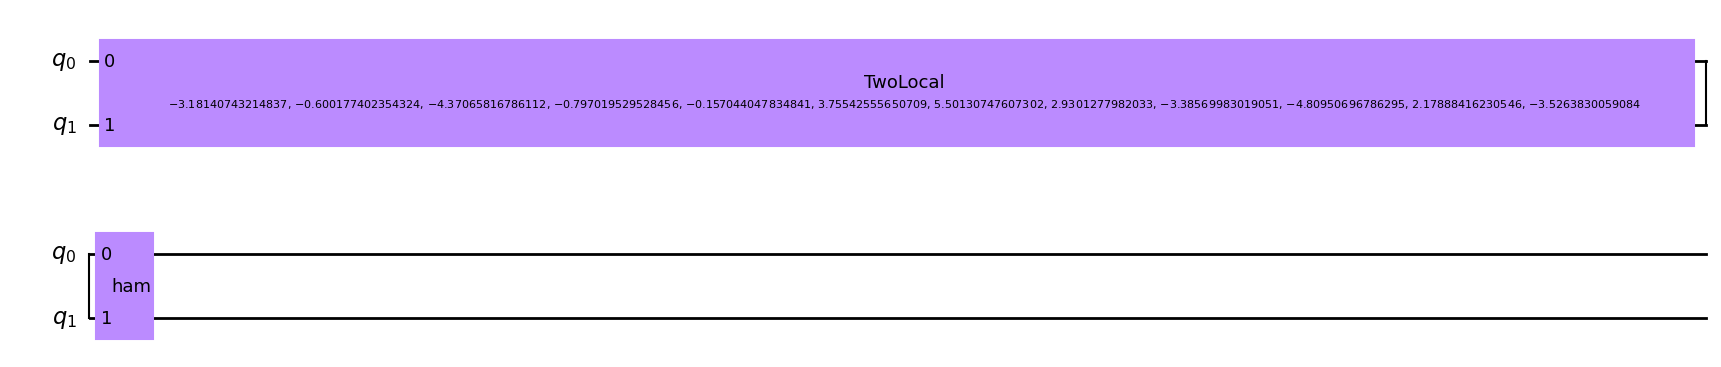

In [15]:
# Obtención de los vectores de estado intermedios y final

SVansatz = np.round(Statevector.from_instruction(cir),3) 
cir.unitary(ham.to_matrix(), [0, 1],'ham')
SVham = np.round(Statevector.from_instruction(cir),3)
cir.draw('mpl')


#### Estado que sintetiza el ansatz

In [16]:
array_to_latex(SVansatz)

<IPython.core.display.Latex object>

#### Estado final que fuerza el hamiltoniano

In [17]:
array_to_latex(SVham)

<IPython.core.display.Latex object>

Que coincide con el valor teórico calculado.

#### Comentarios:

 H|SVansatz> = -|SVansatz>, es decir  λ=-1

Es el mismo estado pero con fase global de 180ª

#### Pesos posicionales en  los diagramas circuitales de qiskit

En el seguimiento algebraico de la evolución del estado inicial hay que tener en cuenta el peso posicional de los qbits en los diagranas circuitales de qiskit, que es el contrario al estándar, lo que altera la representación numérica de los operadores.

Así, para el operador CNOT, el operador equivalente al diagrama circuital qiskit es el siguiente:

In [18]:
H=np.array([[1,0,0,0], [0,0,0,1],[0,0,1,0], [0,1,0,0]],dtype=complex)
H

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j]])


Con autovalores y autovectores:

λ1 = 1

    |v1⟩ = |00⟩        = (0.71,0,0,0)
    |v2⟩ = |10⟩        = (0,0,0.71,0)
    |v3> = |01>+|11>   = (0,0.71,0,0.71)

λ2 = -1

    |v4⟩ = |11⟩ - |01⟩ = (0,-0.71,0,0,71)


Inspiración futura:

https://qiskit.org/textbook/ch-applications/vqe-molecules.html